Step 4: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product

In [2]:
#uncertain graph weights (different click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.Estimate_click_probabilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce()
E.set_lambda(0.5)
E.set_products(products)

#Ecommerce graph weights are uncertain, for each user they are different, but the slots are fixed by the Ecommerce
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])

In [5]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.96651483 0.72976289 0.2487184  0.00853153]
 [0.97979065 0.76258085 0.16115835 0.00764098]
 [0.98947939 0.832832   0.20897294 0.01184433]
 [0.98889446 0.70595994 0.24273454 0.03515701]
 [0.98962704 0.9059408  0.11773662 0.01112219]]
_______________________________________________
Expected rewards per arm
[[ 7.76608369  8.90925742  3.92003975  0.0462661 ]
 [ 5.92655722  6.62315549  1.84315331  0.01078903]
 [23.29186686 27.07884761  8.21683985  0.28076627]
 [46.5385219  43.62859634 17.13176357  2.62375638]
 [39.995      45.73611543  6.55007468  0.        ]]
_______________________________________________
Expected units sold per arm
[[2.  2.  2.  0.4]
 [1.  1.  1.  0.2]
 [3.  3.  3.  1.8]
 [3.  3.  3.  3. ]
 [1.  1.  1.  0. ]]
_______________________________________________
Best configuration [1. 1. 1. 0. 1.]
Optimal cumulative expected reward per round
133.90749356232917


In [6]:
#Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 1
fixed_weights = 0
fixed_units = 1
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []

ts_rewards_per_day = np.zeros(n_days)
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    gr_learner = Greedy(n_arms=n_arms)
    ucb_learner = UCB(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)

        pulled_arm = gr_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)  

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
        ts_rewards_per_day[d] += np.sum(reward)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    gr_rewards_per_experiment.append(gr_learner.collected_rewards)
    cr_rewards_per_experiment.append(cr_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

ts_rewards_per_day = ts_rewards_per_day/n_experiments
ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

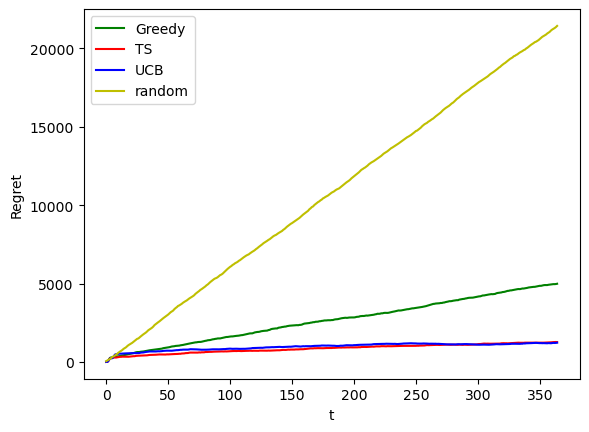

In [7]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - cr_rewards_per_experiment, axis=0)), 'y')
plt.legend(["Greedy","TS","UCB","random"])
plt.show()

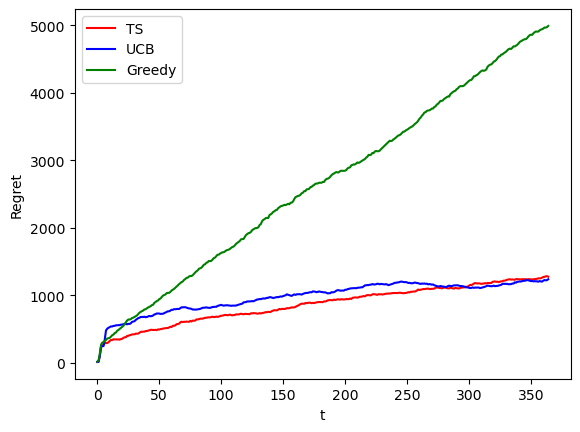

In [8]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS","UCB","Greedy"])
plt.show()

In [9]:
print("_______________________________________________")
print("TS Total collected reward")
print(np.sum(np.mean(ts_rewards_per_experiment,axis=0)))
print("UCB Total collected reward")
print(np.sum(np.mean(ucb_rewards_per_experiment,axis=0)))
print("_______________________________________________")

print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("UCB",np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print("TS",np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))
print("UCB",np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print("TS",np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))
print("UCB",np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))

_______________________________________________
TS Total collected reward
47602.76170666667
UCB Total collected reward
47641.00317833333
_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days and its standard deviation considering 10 experiments
TS 47602.76170666667 863.8270531610237
UCB 47641.00317833334 547.729664233552
-----------------------------------------------
Total expected regret over 365 days and its standard deviation considering 10 experiments
TS 1273.4734435834757 863.8270531610258
UCB 1235.2319719168092 547.7296642335523
-----------------------------------------------
Average expected reward per round over 365 days and its standard deviation between the rounds considering 10 experiments
TS 130.4185252237443 9.724108968641188
UCB 130.52329637899544 13.235268738320606
-----------------------------------------------
Average expected regret per round over 365 days a

In [10]:
print("TS Pulls per arm")
for i in range(len(ts_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ts_pulls_per_arm_per_experiment[i])

TS Pulls per arm
_______________________________________________
[[  7. 356.   1.   1.]
 [362.   1.   1.   1.]
 [  2. 361.   1.   1.]
 [349.   8.   7.   1.]
 [  1. 362.   1.   1.]]
_______________________________________________
[[  7. 356.   1.   1.]
 [ 13. 350.   1.   1.]
 [  4. 359.   1.   1.]
 [308.  55.   1.   1.]
 [362.   1.   1.   1.]]
_______________________________________________
[[  3. 348.  13.   1.]
 [193. 170.   1.   1.]
 [  2. 361.   1.   1.]
 [270.  89.   5.   1.]
 [  4. 359.   1.   1.]]
_______________________________________________
[[  1. 354.   9.   1.]
 [ 39. 324.   1.   1.]
 [  2. 349.  13.   1.]
 [121. 242.   1.   1.]
 [353.   1.  10.   1.]]
_______________________________________________
[[ 86. 269.   1.   9.]
 [  7. 356.   1.   1.]
 [362.   1.   1.   1.]
 [316.  43.   5.   1.]
 [  3. 360.   1.   1.]]
_______________________________________________
[[  1. 362.   1.   1.]
 [  1. 362.   1.   1.]
 [  2. 361.   1.   1.]
 [285.  71.   8.   1.]
 [  6. 357.   1.   1.]]

In [11]:
print("UCB Pulls per arm")
for i in range(len(ucb_pulls_per_arm_per_experiment)):
    print("_______________________________________________")
    print(ucb_pulls_per_arm_per_experiment[i])

UCB Pulls per arm
_______________________________________________
[[ 52. 307.   2.   4.]
 [ 62. 297.   2.   4.]
 [ 25. 333.   5.   2.]
 [186. 175.   2.   2.]
 [ 45. 316.   2.   2.]]
_______________________________________________
[[ 46. 308.   9.   2.]
 [ 74. 286.   3.   2.]
 [ 46. 314.   3.   2.]
 [256. 100.   7.   2.]
 [ 49. 309.   5.   2.]]
_______________________________________________
[[ 43. 306.  14.   2.]
 [147. 214.   2.   2.]
 [ 55. 306.   2.   2.]
 [228. 133.   2.   2.]
 [ 54. 307.   2.   2.]]
_______________________________________________
[[ 40. 318.   5.   2.]
 [ 85. 276.   2.   2.]
 [ 68. 280.  13.   4.]
 [171. 179.  13.   2.]
 [ 63. 298.   2.   2.]]
_______________________________________________
[[ 50. 302.  11.   2.]
 [ 75. 280.   6.   4.]
 [ 41. 320.   2.   2.]
 [265.  92.   4.   4.]
 [ 72. 289.   2.   2.]]
_______________________________________________
[[ 58. 298.   7.   2.]
 [ 69. 292.   2.   2.]
 [ 47. 314.   2.   2.]
 [200. 161.   2.   2.]
 [ 64. 297.   2.   2.]

In [12]:
#Theoretical bounds for TS
KL = np.zeros(n_days)
for i in range(n_days):
    KL[i] = opt * np.log(opt / ts_rewards_per_day[i])
delta_ts = opt - ts_rewards_per_day
UPPER_bound_regret_ts = (1 + 10) * np.log(ts_learner.t) + np.log(np.log(ts_learner.t)) * np.sum(delta_ts / KL)
empiric_regret_ts = np.sum(opt - ts_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the TS regret")
print(UPPER_bound_regret_ts)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_ts / UPPER_bound_regret_ts)

#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4 * np.log(ucb_learner.t) * np.sum(1 / delta_ucb + 8 * delta_ucb)
empiric_regret_ucb = np.sum(opt - ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print(empiric_regret_ucb / UPPER_bound_regret_ucb)

_______________________________________________
Upper bound for the TS regret
703.6197346532579
_______________________________________________
Ratio between empirical regret and upper bound for the regret
1.8098887522122151
_______________________________________________
Upper bound for the UCB regret
230753.33654824758
_______________________________________________
Ratio between empirical regret and upper bound for the regret
0.00535304056874834


In [13]:
#Comparison between TS and UCB with respect to the number of users per round

n_arms = 4
num_users = 10
n_days = 1000
fixed_alpha = 0
fixed_weights = 0
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment_10 = []
ucb_rewards_per_experiment_10 = []

ts_rewards_per_experiment_100 = []
ucb_rewards_per_experiment_100 = []


ts_rewards_per_experiment_1000 = []
ucb_rewards_per_experiment_1000 = []


for e in range(n_experiments):

    env_10 = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_10 = UCB(n_arms=n_arms)
    ts_learner_10 = TS_poisson(n_arms=n_arms)

    env_100 = Environment(n_arms, E, margins_matrix, num_users*10, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_100 = UCB(n_arms=n_arms)
    ts_learner_100 = TS_poisson(n_arms=n_arms)

    env_1000 = Environment(n_arms, E, margins_matrix, num_users*100, fixed_alpha, fixed_weights, fixed_units)
    ucb_learner_1000 = UCB(n_arms=n_arms)
    ts_learner_1000 = TS_poisson(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner_10.pull_arm()
        reward = env_10.round(pulled_arm)
        ucb_learner_10.update(pulled_arm, reward)

        pulled_arm = ucb_learner_100.pull_arm()
        reward = env_100.round(pulled_arm)
        ucb_learner_100.update(pulled_arm, reward)

        pulled_arm = ucb_learner_1000.pull_arm()
        reward = env_1000.round(pulled_arm)
        ucb_learner_1000.update(pulled_arm, reward)
        
        pulled_arm = ts_learner_10.pull_arm(env_10.margins_matrix)
        reward = env_10.round(pulled_arm)
        ts_learner_10.update(pulled_arm, reward, env_10.clicks_current_day, env_10.purchases_current_day, env_10.daily_units)

        pulled_arm = ts_learner_100.pull_arm(env_100.margins_matrix)
        reward = env_100.round(pulled_arm)
        ts_learner_100.update(pulled_arm, reward, env_100.clicks_current_day, env_100.purchases_current_day,  env_100.daily_units)

        pulled_arm = ts_learner_1000.pull_arm(env_1000.margins_matrix)
        reward = env_1000.round(pulled_arm)
        ts_learner_1000.update(pulled_arm, reward, env_1000.clicks_current_day, env_1000.purchases_current_day,  env_1000.daily_units)

    ts_rewards_per_experiment_10.append(ts_learner_10.collected_rewards)
    ucb_rewards_per_experiment_10.append(ucb_learner_10.collected_rewards)

    
    ts_rewards_per_experiment_100.append(ts_learner_100.collected_rewards)
    ucb_rewards_per_experiment_100.append(ucb_learner_100.collected_rewards)

    
    ts_rewards_per_experiment_1000.append(ts_learner_1000.collected_rewards)
    ucb_rewards_per_experiment_1000.append(ucb_learner_1000.collected_rewards)


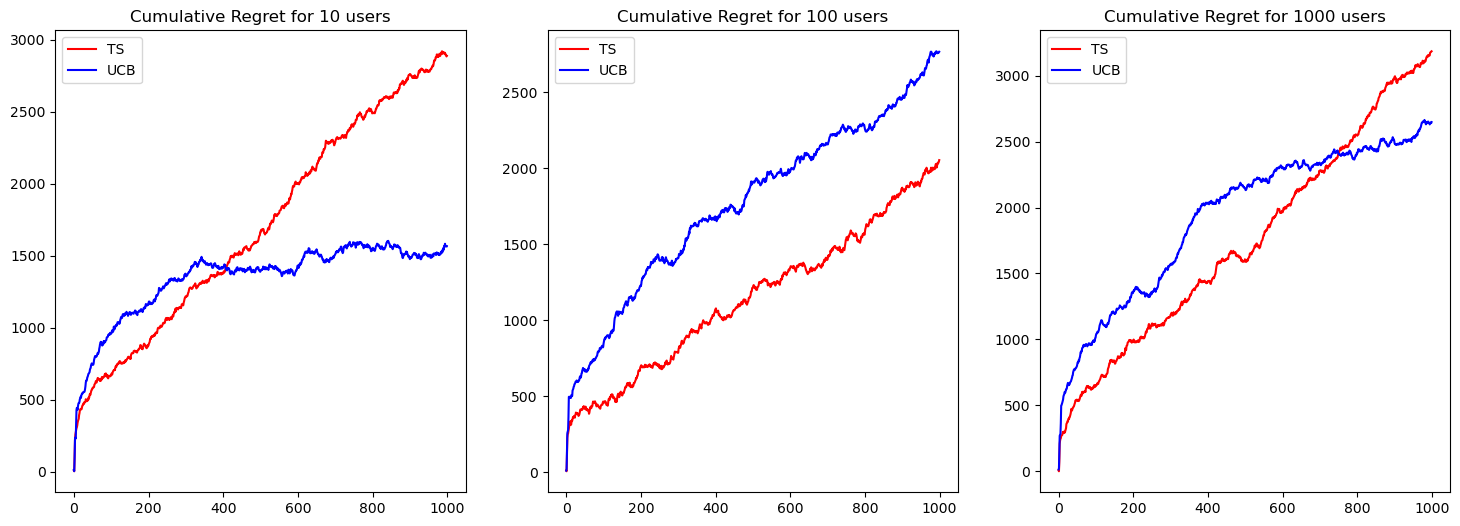

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,6))
ax[0].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_10, axis=0)), 'r')
ax[0].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_10, axis=0)), 'b')
ax[0].set_title("Cumulative Regret for 10 users")
ax[0].legend(["TS","UCB"])

ax[1].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_100, axis=0)), 'r')
ax[1].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_100, axis=0)), 'b')
ax[1].set_title("Cumulative Regret for 100 users")
ax[1].legend(["TS","UCB"])

ax[2].plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment_1000, axis=0)), 'r')
ax[2].plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment_1000, axis=0)), 'b')
ax[2].set_title("Cumulative Regret for 1000 users")
ax[2].legend(["TS","UCB"])

plt.show()